In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report
# The SGDClassifier (stochastic) relies on randomness during training
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
%matplotlib inline

In [2]:
# This is because each image is 784 = 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).
mnist = fetch_openml("mnist_784", version=1) # 784 = 28 * 28 pixel, standard version containing 70,000 samples (60,000 train + 10,000 test).
dir(mnist)

['DESCR',
 'categories',
 'data',
 'details',
 'feature_names',
 'frame',
 'target',
 'target_names',
 'url']

In [3]:
mnist['target'].unique() # 0 - 9 classes

['5', '0', '4', '1', '9', '2', '3', '6', '7', '8']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB


In [6]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 70000 entries, 0 to 69999
Series name: class
Non-Null Count  Dtype   
--------------  -----   
70000 non-null  category
dtypes: category(1)
memory usage: 68.9 KB


In [7]:
y = y.astype('int16')
y.unique()

array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8], dtype=int16)

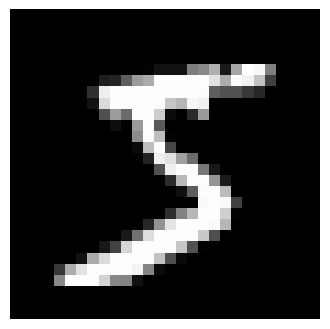

In [8]:
plt.figure(figsize=(4,5))
plt.imshow(X.loc[0].to_numpy().reshape(28,28), cmap="grey") # turns the 784-length vector into a 28×28 pixel image.
plt.axis("off")
plt.show()

In [9]:
y[0]

np.int16(5)

In [10]:
# The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [11]:
# shuffling the dataset to insure that all cross-validation folds will be similar
shuffle_index = np.random.permutation(60000)
shuffle_index

array([28942, 59463, 30196, ..., 25018, 20755, 40619],
      shape=(60000,), dtype=int32)

In [12]:
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

# Scaling the Train and Test input data

In [13]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((60000, 784), (10000, 784))

# Training a binary classifier to classify if the digit is 5 or not (One Versus All / One Versus Rest (OVA) )

In [14]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [15]:
y_train_5.unique()

array([False,  True])

In [16]:
sgd_clf = SGDClassifier(loss="log_loss", random_state=42)
sgd_clf.fit(X_train_scaled, y_train_5)

SGDClassifier(loss='log_loss', random_state=42)

In [17]:
y_train_predicted5 = sgd_clf.predict(X_train_scaled) 
y_test_predicted5 = sgd_clf.predict(X_test_scaled)
print(f" Binary classification train accuracy 5: {accuracy_score(y_train_predicted5, y_train_5):.2f}")
print(f" Binary classification test accuracy 5: {accuracy_score(y_test_predicted5, y_test_5):.2f}")

 Binary classification train accuracy 5: 0.97
 Binary classification test accuracy 5: 0.97


# Implementation using StratifiedKFold cross validation

In [18]:
# StratifiedKFold(...).split(X, y) gives you training/test indices while keeping class proportions.
# Each fold uses a different 20% test set, but all maintain balanced digit class distribution (very important for MNIST).
skf = StratifiedKFold(n_splits=5, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(X_train_scaled, y_train_5)):
    print(f"Splitting fold {fold}")
    X_train5, X_val5 = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train5, y_val5 = y_train_5.loc[train_index], y_train_5.loc[test_index]

    model = SGDClassifier(loss="log_loss", random_state=42)
    model.fit(X_train5, y_train5)
    y_val_pred = model.predict(X_val5)
    acc = accuracy_score(y_val5, y_val_pred)
    print(f"Fold {fold} has accuracy {acc:.2f}")

Splitting fold 0
Fold 0 has accuracy 0.90
Splitting fold 1
Fold 1 has accuracy 0.91
Splitting fold 2
Fold 2 has accuracy 0.90
Splitting fold 3
Fold 3 has accuracy 0.90
Splitting fold 4
Fold 4 has accuracy 0.91


##### Or,

In [19]:
# Alternatively use cross_val_score with Stratified KFold
scores = cross_val_score(sgd_clf, X_train_scaled, y_train_5, cv=StratifiedKFold(n_splits=5), scoring="accuracy")
print(scores)

[0.969      0.96841667 0.96975    0.96883333 0.97025   ]


# Confusion Matrix

### Using cross_val_predict  
Similar to cross_val_score(), but returns predictions instead of accuracy score

In [20]:
y_train_5_predict = cross_val_predict(sgd_clf, X_train_scaled, y_train_5, cv=StratifiedKFold(n_splits=5))

In [21]:
cm = confusion_matrix(y_train_5, y_train_5_predict)
cm

array([[53961,   618],
       [ 1227,  4194]])

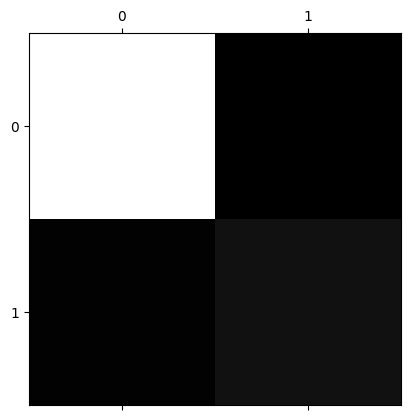

In [22]:
plt.matshow(cm, cmap=plt.cm.gray)
plt.show()

##### Interpretention:  
True Negatives: The first row of this matrix considers non-5 images (the negative class): 53,953 of them were correctly classified as non-5s.   
False Positives: while the remaining 626 were wrongly classified as 5s.  
The second row considers the images of 5s (the positive class).  
False Negatives: 1,200 were wrongly classified as non-5s.  
True Positives: while the remaining 4,221 were correctly classified as 5s.    
A perfect classifier would have only true positives and true negatives.  

# Precision & Recall  
Precision: Accuracy of the positive predictions (TP/(TP+FP))  
Recall(Sensitivity / True Positive Rate): Ratio of positive instances that are correctly detected by the classifier (TP/(TP+FN))

In [23]:
print(f"Precision Score: {precision_score(y_train_5, y_train_5_predict)}")
print(f"Recall Score: {recall_score(y_train_5, y_train_5_predict)}")

Precision Score: 0.871571072319202
Recall Score: 0.7736579966795795


Observation:  
So, When our classifier claims an image represents a 5, it is only accurate 87% of the time.  
Moreover, it only detects 77% of the 5s.  

# F1 Score: Harmonic mean of precision and recall  
f1_score = 2/(1/precision + 1/recall) = TP/(TP+((FP+FN)/2))  
Precision/Recall tradeoff: Increasing precision reduces recall, and vice versa.  

In [24]:
print(f"F1_score: {f1_score(y_train_5, y_train_5_predict)}")

F1_score: 0.8197009674582234


# Precision Recall curve -  Preferred when the positive class is rare

##### Instead of predict(), we can call the decision_function to get regression scores and set a threshold ourselves score>threshold i.e. it's a 5, otherwise not.

In [25]:
sgd_clf.decision_function(X_train_scaled)

array([-262.83852903, -616.99364799, -502.62103004, ..., -358.43784629,
       -367.09119272,  -31.36599023], shape=(60000,))

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train_scaled, y_train_5, cv=StratifiedKFold(n_splits=5), method="decision_function")
y_scores

array([-329.83751403, -777.16014269, -635.76639027, ..., -384.31495541,
       -398.73149199,  -28.29314383], shape=(60000,))

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
len(precisions), len(recalls), len(thresholds)

(60001, 60001, 60000)

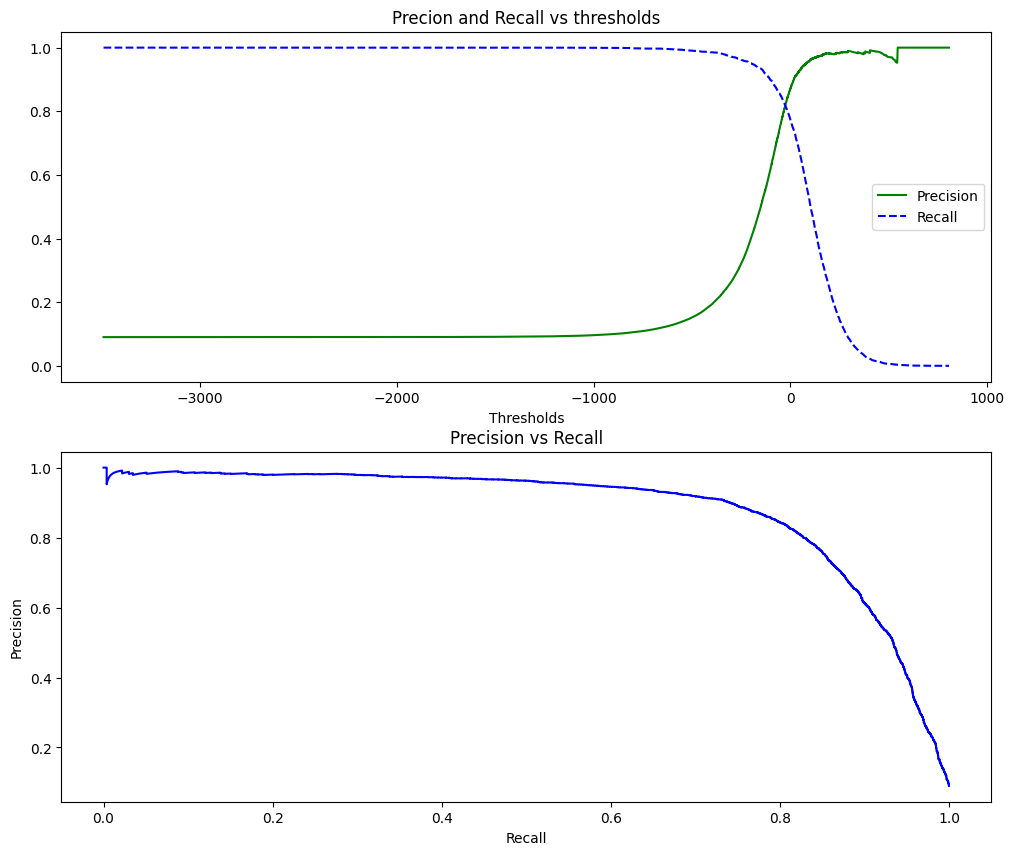

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
ax[0].plot(thresholds, precisions[:-1], c="g", linestyle="solid", label="Precision")
ax[0].plot(thresholds, recalls[:-1], c="b", linestyle="--", label="Recall")
ax[0].set_title("Precion and Recall vs thresholds")
ax[0].set_xlabel("Thresholds")
ax[0].legend(loc="best")

ax[1].plot(recalls, precisions, c='b', linestyle="solid")
ax[1].set_title("Precision vs Recall")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

# Receiver Operating Characteristic (ROC) curve  - Used otherwise
ROC curve plots the true positive rate (recall) against the false positive rate.  
FPR = 1 - TNR(or specifity)   
ROC curve plots TPR/sensitivity/recall versus 1 – specificity.

In [29]:
fpr, tpr, thrsholds = roc_curve(y_train_5, y_scores)

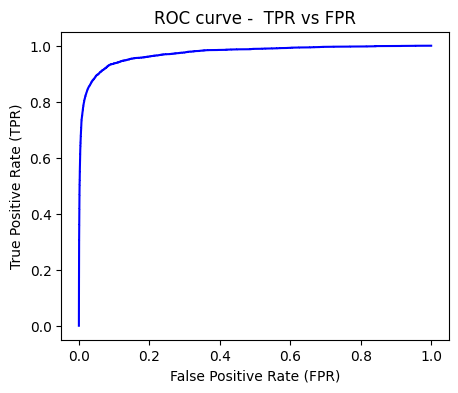

In [30]:
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, c="b", linestyle="solid")
plt.title("ROC curve -  TPR vs FPR")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.show()

# Area under the curve (AUC)  
A perfect classifier will have ROC AUC = 1

In [31]:
roc_auc_score(y_train_5, y_scores) # SGD classifier

np.float64(0.9728959704600583)

### Training a Random forest classifier to compare with Stochastic Gradient Classifier(SGD)

In [32]:
rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train_scaled, y_train_5, cv=StratifiedKFold(n_splits=5), method="predict_proba")
y_probas_forest

array([[0.99, 0.01],
       [0.98, 0.02],
       [0.98, 0.02],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.89, 0.11]], shape=(60000, 2))

In [33]:
y_scores_forest = cross_val_predict(rf_clf, X_train_scaled, y_train_5, cv=StratifiedKFold(n_splits=5), method="predict")

In [34]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

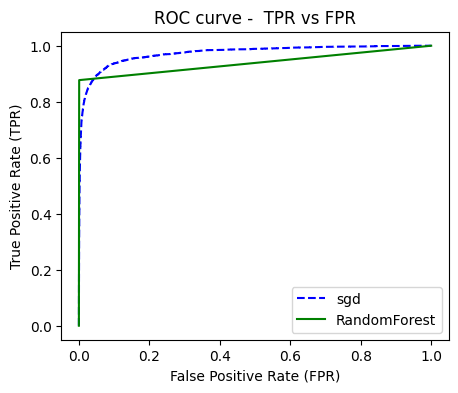

In [35]:
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, c="b", linestyle="dashed", label="sgd")
plt.plot(fpr_forest, tpr_forest, c="g", linestyle="solid", label="RandomForest")
plt.title("ROC curve -  TPR vs FPR")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='best')
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores_forest) # Random forest

np.float64(0.9381691337119685)

# Multiclass Classification(Multinomial Classifiers) - Classifing more than two classes

We can use OneVsOneClassifier(OVO) or One Versus All/OneVsRestClassifier class  
OneVsRest -  We saw the usecase before our 5 detector. We trained 5VsAll other classes. (Preferred for most binary classifiers).  
OneVsOne -  It would be like training 45 classifiers for the MNIST dataset such as 0vs1, 0vs2, 1Vs2 and so on (N*(N-1))/2 classifiers, N=No. of classes.
(Preferred for SVM classifier, since it scales poorly with large training sets)

##### Forcing OneVsOne classifier on SGD classifier (usually we use here OneVsRest Classifier).

In [37]:
ovo_clf = OneVsOneClassifier(SGDClassifier(loss="log_loss", random_state=42))
ovo_clf.fit(X_train_scaled, y_train)
y_train_predicted_sgd = ovo_clf.predict(X_train_scaled)

In [38]:
len(ovo_clf.estimators_)

45

In [39]:
print(f"Train Accuracy : {accuracy_score(y_train, y_train_predicted_sgd)}")
print(f"Train Precision : {precision_score(y_train, y_train_predicted_sgd, average='macro')}") # average='macro' (average) needs to be set for multiclass classification
print(f"Train Recall : {recall_score(y_train, y_train_predicted_sgd, average='macro')}")
print(f"Train F1-score: {f1_score(y_train, y_train_predicted_sgd, average='macro')}")

Train Accuracy : 0.9557833333333333
Train Precision : 0.9554645797420038
Train Recall : 0.9551914660693974
Train F1-score: 0.9552982965526269


In [40]:
y_test_predicted_sgd = ovo_clf.predict(X_test_scaled)

In [41]:
print(f"Test Accuracy : {accuracy_score(y_test, y_test_predicted_sgd)}")
print(f"Test Precision : {precision_score(y_test, y_test_predicted_sgd, average='macro')}") # average='macro' (average) needs to be set for multiclass classification
print(f"Test Recall : {recall_score(y_test, y_test_predicted_sgd, average='macro')}")
print(f"Test F1-score: {f1_score(y_test, y_test_predicted_sgd, average='macro')}")

Test Accuracy : 0.9244
Test Precision : 0.9239819421444544
Test Recall : 0.9233481928446732
Test F1-score: 0.9235333865386341


##### Multiclass classification using Random Forest classifier (Doesnot needs OVO or OVA, can directly classify multiclass output)  
Random Forest Classifier and Naive Bayes Classifier can handle multi class classification automatically.  

In [42]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train)
y_train_predicted_rf = rf_clf.predict(X_train_scaled)

In [43]:
rf_clf.predict_proba(X_train_scaled)

array([[0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.03],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.97, 0.  , 0.  , ..., 0.  , 0.01, 0.01],
       ...,
       [0.  , 0.  , 0.01, ..., 0.02, 0.83, 0.02],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, ..., 0.  , 0.03, 0.03]], shape=(60000, 10))

In [44]:
print(f"Train Accuracy : {accuracy_score(y_train, y_train_predicted_rf)}")
print(f"Train Precision : {precision_score(y_train, y_train_predicted_rf, average='macro')}") # average='macro' (average) needs to be set for multiclass classification
print(f"Train Recall : {recall_score(y_train, y_train_predicted_rf, average='macro')}")
print(f"Train F1-score: {f1_score(y_train, y_train_predicted_rf, average='macro')}")

Train Accuracy : 1.0
Train Precision : 1.0
Train Recall : 1.0
Train F1-score: 1.0


In [45]:
y_test_predicted_rf = rf_clf.predict(X_test_scaled)

In [46]:
print(f"Test Accuracy : {accuracy_score(y_test, y_test_predicted_rf)}")
print(f"Test Precision : {precision_score(y_test, y_test_predicted_rf, average='macro')}") # average='macro' (average) needs to be set for multiclass classification
print(f"Test Recall : {recall_score(y_test, y_test_predicted_rf, average='macro')}")
print(f"Test F1-score: {f1_score(y_test, y_test_predicted_rf, average='macro')}")

Test Accuracy : 0.9695
Test Precision : 0.9693723362604783
Test Recall : 0.9692224007797892
Test F1-score: 0.9692771356864688


In [47]:
roc_auc_score(y_test, y_test_predicted_rf)

ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
fpr, tpr, thrsholds = roc_curve(y_test, y_test_predicted_rf)

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, c="b", linestyle="solid")
plt.title("ROC curve -  TPR vs FPR")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_predicted_rf)

In [ ]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

# Multilabel Classification - A classifier that outputs multiple binary labels for an instance.  
Example: Recognising faces in a picture. An algorithm trained to recognise Alice, Bob and Charlie identifies Alice and Charlie in a picture. Output: [1,0,1].  

##### Training a multilabel classifier to detect if a digit is larger than 7 and is odd or not

In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 != 0)
y_train_multilabel = np.c_[y_train_large, y_train_odd]

y_test_large = (y_test >= 7)
y_test_odd = (y_test % 2 != 0)
y_test_multilabel = np.c_[y_test_large, y_test_odd]

In [ ]:
knn_clf = MultiOutputClassifier(KNeighborsClassifier())
knn_clf = knn_clf.fit(X_train_scaled, y_train_multilabel)
y_train_multilabel_predicted = cross_val_predict(knn_clf, X_train_scaled, y_train_multilabel, cv=5)

In [ ]:
print(f"Train Accuracy : {accuracy_score(y_train_multilabel, y_train_multilabel_predicted)}")
print(f"Train Precision : {precision_score(y_train_multilabel, y_train_multilabel_predicted, average='weighted')}") # average='weighted' give more weighted to the one that has more no. of instances
print(f"Train Recall : {recall_score(y_train_multilabel, y_train_multilabel_predicted, average='weighted')}")
print(f"Train F1-score: {f1_score(y_train_multilabel, y_train_multilabel_predicted, average='weighted')}")

In [ ]:
y_test_multilabel_predicted = knn_clf.predict(X_test_scaled)

In [ ]:
print(f"Test Accuracy : {accuracy_score(y_test_multilabel, y_test_multilabel_predicted)}")
print(f"Test Precision : {precision_score(y_test_multilabel, y_test_multilabel_predicted, average='weighted')}") # average='weighted' give more weighted to the one that has more no. of instances
print(f"Test Recall : {recall_score(y_test_multilabel, y_test_multilabel_predicted, average='weighted')}")
print(f"Test F1-score: {f1_score(y_test_multilabel, y_test_multilabel_predicted, average='weighted')}")

In [ ]:
roc_auc_score(y_test_multilabel, y_test_multilabel_predicted)

In [ ]:
print(classification_report(y_test_multilabel, y_test_multilabel_predicted, target_names=["Large>=7", "Odd"]))